# Notebook to process Kaggle's Titanic dataset

This notebook uses the dataset from Kaggle's Titanic Comptetition to train a logistic regression and provides results with the test dataset
https://www.kaggle.com/c/titanic

author: drublackberry (github)

## Configuration
User configuration parameters

In [1]:
train_size = 80 # % of the training set used for training
N_MonteCarlo = 50 # number of runs for the monte-carlo analysis

## Data pre-processing and exploratory data analysis
Gather the train dataset, convert feature to numerical values and plot the values in stacked histograms to get a feeling of the importance of the features.

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydot
from IPython.display import Image, display


def assignNumericalType (aSeries):
    '''Assigns a numerical type to string values'''
    val = aSeries.unique()
    myDict = {val[x]:x for x in range(len(val))}
    myDict[np.nan] = np.nan # Ensure nan stays nan
    aOut = [myDict[x] for x in aSeries]
    return aOut
    
# Load into CSV
myInDf = pd.read_csv('train.csv', index_col=0)

# Convert strings to numerical type
for myCol in myInDf.columns:
    if type(myInDf[myCol].dropna().iloc[0])==str:
        myInDf[myCol] = assignNumericalType(myInDf[myCol])

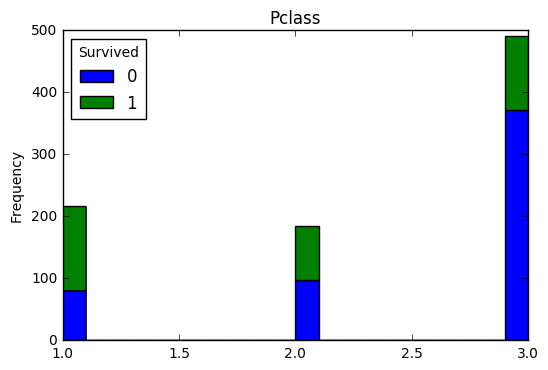

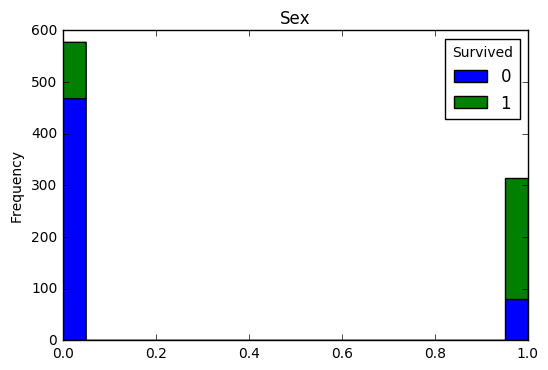

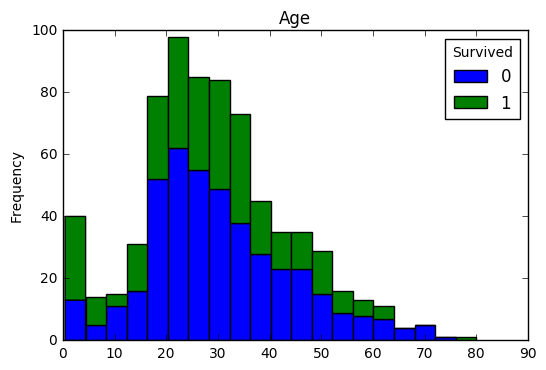

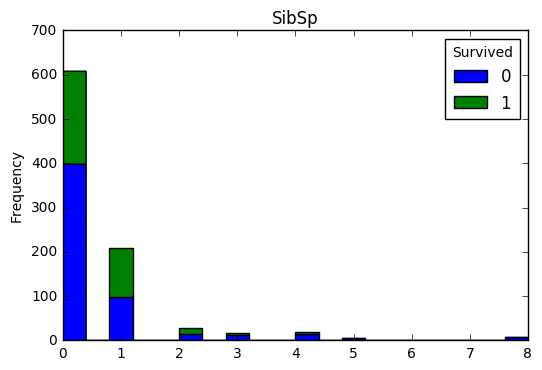

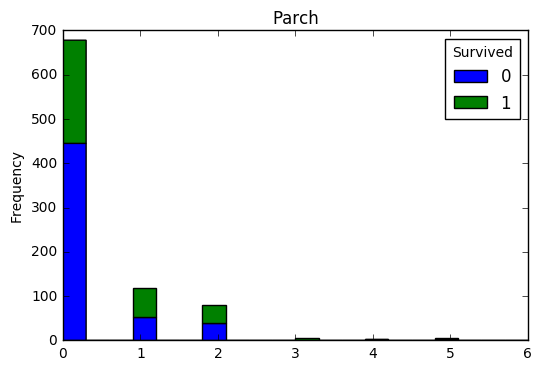

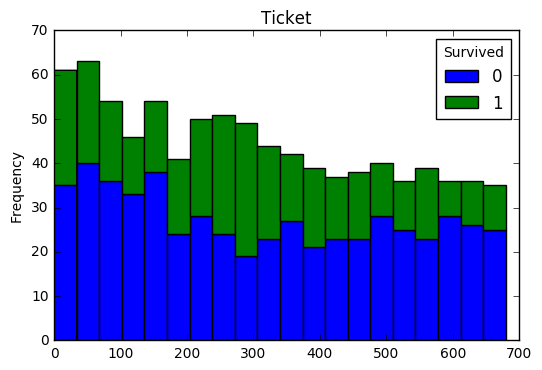

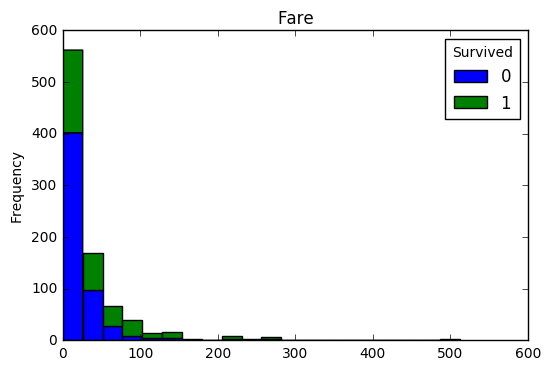

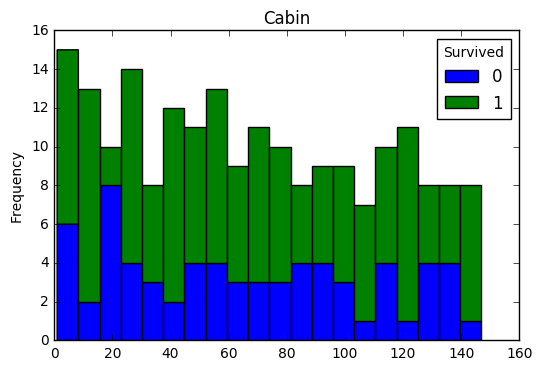

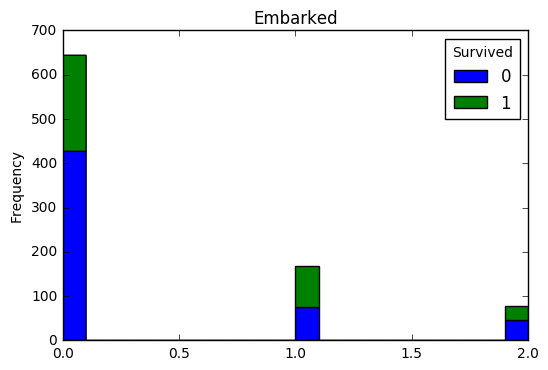

In [3]:
# Exploratory data analysis
for myFeature in myInDf.columns:
    if myFeature != 'Survived' and (len(myInDf[myFeature]) > len(myInDf[myFeature].unique())):
        myInDf.pivot(columns='Survived', values=myFeature).plot(kind='hist', stacked=True, bins=20)
        plt.title(myFeature)
        plt.show()

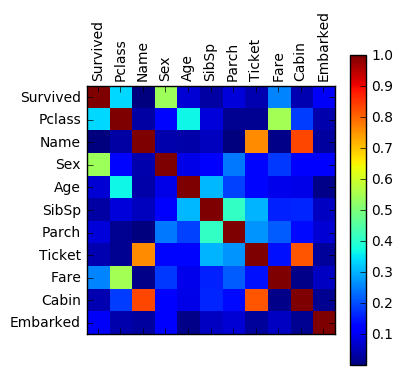

In [49]:
# Do a correlation plot
cax = plt.matshow(myInDf.corr().abs())
plt.colorbar(cax)
plt.xticks(range(len(myInDf.columns)), myInDf.columns, rotation='vertical')
plt.yticks(range(len(myInDf.columns)), myInDf.columns, rotation='horizontal')
plt.show()

## Conclusions of the exploratory data analysis

* Passenger on the age 20-40 are more likely to die.
* Babies and infants are more likely to survive.
* Most passenger where in the range 20-40 with children (i.e. families).
* Older people is more likely to survive
* Lower fares are more likely to die
* People with more than 3 siblings is likely to die
* Travelling with no siblings meant a higher change of survival
* People not related to children are more likely to die
* There is a clear dependence on passenger class
* Males are more likely to die
* There is a certain dependence on the cabin, port and ticket
* There is high correlation of hte survival with sex, pclass and . Weaker correlations with parch and embarked.

## Missing data
A part of the dataset is missing, how many missing values do we have in the training set per feature?

In [4]:
myMissingDf = pd.DataFrame(columns=['Missing', 'Total'], index=myInDf.columns)
myMissingDf['Missing'] = myInDf.isnull().sum()
myMissingDf['Total'] = myInDf.count()
myMissingDf

,Missing,Total
Survived,0,891
Pclass,0,891
Name,0,891
Sex,0,891
Age,177,714
SibSp,0,891
Parch,0,891
Ticket,0,891
Fare,0,891
Cabin,687,204


Given the results one can conclude that
* The age is missing for a number of passengers but it is still a usable feature given the amount of it that is missing
* The cabin is missing for large part of the dataset, if used as feature it will have little weight
* Two passenger are missing the port where they embarked, the feature should be still usable

The age feature is specially interesting given the high correlation with the survival

# Classification using decision trees

In [9]:
from sklearn import tree
from sklearn.metrics import precision_score, recall_score, f1_score
    
def splitDataset (aDf, aFrac):
    '''Splits a Df in a training and a validation dataset randomly'''
    aTrainDf = aDf.sample(frac=aFrac/100.)
    myValInd = [ind for ind in aDf.index if ind not in aTrainDf.index]
    aValDf = aDf.loc[myValInd]
    # Create X and Y datasets
    aXtrain = aTrainDf[[x for x in aTrainDf.columns if x!='Survived']]
    aYtrain = aTrainDf['Survived']
    aXval = aValDf[[x for x in aTrainDf.columns if x!='Survived']]
    aYval = aValDf['Survived']
    return aXtrain, aYtrain, aXval, aYval

def assessPerformance (aX, aY, aClf):
    '''Prints the performance of a certain machine learning algorithm'''
    myYpred = aClf.predict(aX)
    aPrecision = precision_score(aY, myYpred)
    aRecall = recall_score(aY, myYpred)
    aF1score = f1_score(aY, myYpred)
    return aPrecision, aRecall, aF1score

def trainPredictAndAnalyze (aDf, aDepth=None, draw=False):
    # Build a decision tree classifier
    myXtrain, myYtrain, myXval, myYval = splitDataset (aDf, train_size)
    myClf = tree.DecisionTreeClassifier(max_depth=aDepth)
    myClf = myClf.fit(myXtrain, myYtrain)
    aTrainPrecision, aTrainRecall, aTrainF1 = assessPerformance(myXtrain, myYtrain, myClf)
    aValPrecision, aValRecall, aValF1 = assessPerformance(myXval, myYval, myClf)
    if draw:
        # Draw the decision tree
        myDotData = tree.export_graphviz(myClf, feature_names=myXtrain.columns, out_file='tree.dot' )
        (myGraph,) = pydot.graph_from_dot_file('tree.dot')
        myPlt = Image(myGraph.create_png())
        myGraph.write_png('tree.png')
        display(myPlt)
    return aTrainPrecision, aTrainRecall, aTrainF1, aValPrecision, aValRecall, aValF1
   
def runMonteCarlo (aDf, aDepth=None):
    myPerfDf = pd.DataFrame(columns=['Train Precision', 'Train Recall', 'Train F1', 'Val Precision', 'Val Recall', 'Val F1'])
    for i in range(N_MonteCarlo):
        myPerfDf.loc[i] = trainPredictAndAnalyze(aDf, aDepth)
    return myPerfDf

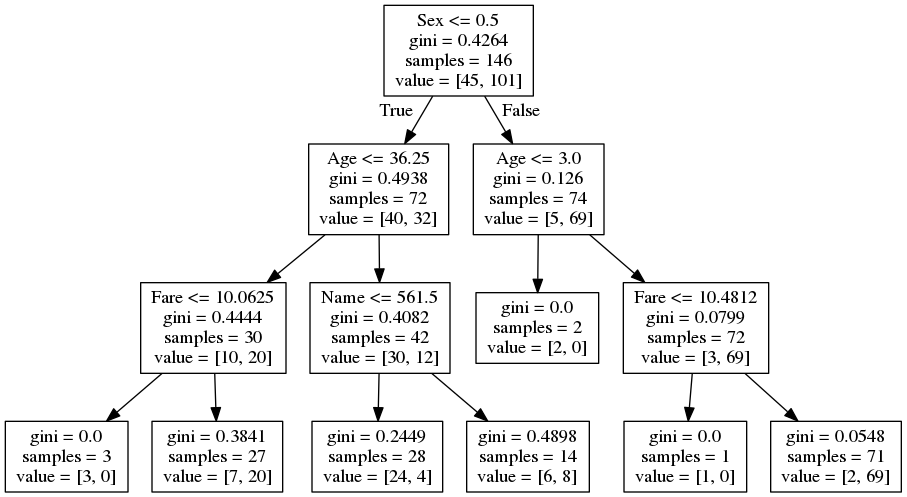

In [10]:
# Calling and drawing a precision tree with max_depth
# Note that this call removes all the nan (large part of the dataset) and just displays a decision tree for illustration
foo = trainPredictAndAnalyze(myInDf.dropna(), aDepth=3, draw=True)

Try out different cleaning methods for the data, since the data has many missing values

In [27]:
# Removing all the features with nan values on it
from sklearn.preprocessing import Imputer
myImp = Imputer(missing_values='NaN', strategy='mean', axis=1)
myImp.fit(myInDf)
myNewDf = pd.DataFrame(myImp.transform(myInDf), columns=myInDf.columns)
myStats = runMonteCarlo(myNewDf).describe() # capture output of dataframe for further usage
myStats

,Train Precision,Train Recall,Train F1,Val Precision,Val Recall,Val F1
count,50.0,50.0,50.0,50.000000,50.000000,50.000000
mean,1.0,1.0,1.0,0.663638,0.663331,0.661832
std,0.0,0.0,0.0,0.049330,0.056619,0.041589
min,1.0,1.0,1.0,0.557143,0.539683,0.548387
25%,1.0,1.0,1.0,0.636995,0.625000,0.644388
50%,1.0,1.0,1.0,0.669154,0.673849,0.671379
75%,1.0,1.0,1.0,0.699242,0.694220,0.686909
max,1.0,1.0,1.0,0.737500,0.797101,0.753425


In [20]:
# Do not use features which have any value missing
myCompleteFeatures = [x for x in myMissingDf.index if myMissingDf['Missing'].loc[x]==0]
runMonteCarlo(myInDf[myCompleteFeatures]).describe()

,Train Precision,Train Recall,Train F1,Val Precision,Val Recall,Val F1
count,50.0,50.0,50.0,50.000000,50.000000,50.000000
mean,1.0,1.0,1.0,0.660526,0.664238,0.660952
std,0.0,0.0,0.0,0.049365,0.055596,0.042229
min,1.0,1.0,1.0,0.573333,0.500000,0.537815
25%,1.0,1.0,1.0,0.621074,0.626645,0.630395
50%,1.0,1.0,1.0,0.662067,0.661726,0.656916
75%,1.0,1.0,1.0,0.692955,0.699105,0.692911
max,1.0,1.0,1.0,0.805556,0.770492,0.740260


In [23]:
# Do not use the cabin feature and imput with the mean
myColToUse = [x for x in myInDf.columns if x != 'Cabin']
myImp.fit(myInDf[myColToUse])
myNewDf = pd.DataFrame(myImp.transform(myInDf[myColToUse]), columns=myColToUse)
runMonteCarlo(myNewDf).describe()

,Train Precision,Train Recall,Train F1,Val Precision,Val Recall,Val F1
count,50.0,50.0,50.0,50.000000,50.000000,50.000000
mean,1.0,1.0,1.0,0.663894,0.660200,0.659392
std,0.0,0.0,0.0,0.055922,0.069605,0.046771
min,1.0,1.0,1.0,0.527027,0.492958,0.560000
25%,1.0,1.0,1.0,0.631053,0.603721,0.626173
50%,1.0,1.0,1.0,0.671437,0.664583,0.661631
75%,1.0,1.0,1.0,0.692955,0.706575,0.693485
max,1.0,1.0,1.0,0.821429,0.808824,0.758621


In [24]:
runMonteCarlo(myInDf.replace(np.nan, -1)).describe()

,Train Precision,Train Recall,Train F1,Val Precision,Val Recall,Val F1
count,50.0,50.0,50.0,50.000000,50.000000,50.000000
mean,1.0,1.0,1.0,0.677619,0.687271,0.680593
std,0.0,0.0,0.0,0.057840,0.065104,0.050475
min,1.0,1.0,1.0,0.559322,0.554217,0.564103
25%,1.0,1.0,1.0,0.643681,0.644305,0.644013
50%,1.0,1.0,1.0,0.677593,0.695048,0.687023
75%,1.0,1.0,1.0,0.724735,0.731792,0.716418
max,1.0,1.0,1.0,0.800000,0.800000,0.783217


## Prediciting age
Age is a key feature that is missing in a considerable part of the dataset, however, the age can be infered from other features. The predicted age can be used to feed the decision tree.

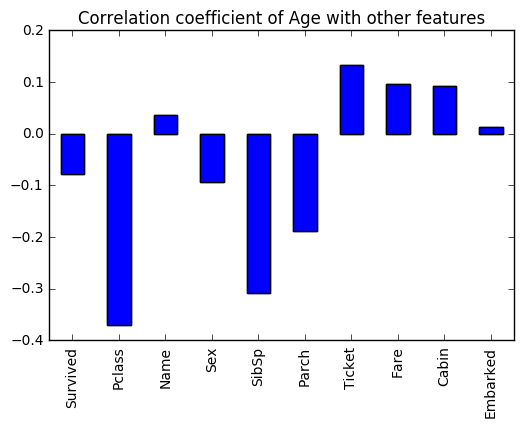

In [63]:
myInDf.corr()[[x for x in myInDf.columns if x != 'Age']].loc['Age'].plot(kind='bar')
plt.title('Correlation coefficient of Age with other features')
plt.show()

In [101]:
# Predict the age with a linear regression
from sklearn import linear_model

myAgeDf = myInDf[['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Age']]
myLR = linear_model.LinearRegression()
myLR.fit (myAgeDf.dropna()[[x for x in myAgeDf.columns if x != 'Age']], myAgeDf.dropna()['Age'])
# Predict and fill the initial dataframe
myXagePred = myAgeDf.loc[myAgeDf.isnull()['Age']][[x for x in myAgeDf.columns if x != 'Age']]
myInDf.loc[myXagePred.index, 'Age'] = myLR.predict(myXagePred)

In [103]:
# Check the results (there should be no nan for the age)
myInDf.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

## Missing embarked values
There are two values with nan for the embarked. Embarked is a feature that holds a certain correlation with the survival rate. It should be better to keep it

In [104]:
myInDf[myInDf['Embarked'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,61,1,38.0,0,0,60,80.0,13.0,NaN
830,1,1,829,1,62.0,0,0,60,80.0,13.0,NaN


## Preventing overtitting

Here a number of draws will be done on the validation set to come up with a level of depth that minimizes the validation error

In [30]:
# Create a MultiIndex dataframe to store the stats of all the different runs
myMaxDepthArray = np.array(range(len(myInDf.columns)))+1
myIndex = pd.MultiIndex.from_product([myMaxDepthArray, myStats.index])
myDf = pd.DataFrame(index=myIndex, columns=myStats.columns)
for myDepth in myMaxDepthArray:
    myDf.loc[myDepth,:].iloc[:] = runMonteCarlo(myInDf.replace(np.nan,-1), aDepth=myDepth).describe().iloc[:]